In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import scipy.signal as sig
import random
import math

## Part 1 
For each file, compute the overall average of three audio features: RMS, spectral centroid, and spectral bandwidth.
You can use a library (e.g. librosa) to compute the spectral bandwidth, while you have to write functions that compute RMS and spectral centroid starting from their definition.
Since you are interested in the average, there is no need to write functions that performs the block analysis (i.e. over small windows/frames) but you can compute the features directly over the entire file.
Compare and display (numerically) the output of your functions vs librosa and explain minor differences if any.

In [2]:
sr = 44100

audio_file = 'Loop.wav'
x, sr = librosa.load(audio_file, sr=44100, mono=True)

**Root Mean Square**

Compute root-mean-square (RMS) value from scratch with the following formula, for each frame of the audio samples.

<font size="5"> $RMS =$ $\sqrt{{\frac{1} {n}} \sum_{i} x_{i}^2}$ </font>

- $n$ is the frame length in samples
- $x_{i} =$ Each frame

In [3]:
def root_mean_square(signal, frame_length, hop_length):
    
    # Pad with the reflection of the signal so that the frames are centered 
    # Padding is achieved by mirroring on the first and last values of the signal with frame_length // 2 samples     
    signal = np.pad(signal, int(frame_length // 2), mode='reflect')
    
    rms = []
    
    for i in range(0, len(signal), hop_length):
        
        rms_formula = np.sqrt(1 / frame_length * np.sum(signal[i:i+frame_length]**2))        
        rms.append(rms_formula)
        
    return np.array(rms)  

**Spectral Centroid**

As the name suggests, a spectral centroid is the location of the centre of mass of the spectrum. Since the audio files are digital signals and the spectral centroid is a measure that can be useful in the characterization of the spectrum of the audio file signal.

<font size="5">$Centroid = \frac{\sum_{n=0}^{N-1} f(n) x(n)} {\sum_{n=0}^{N-1} x(n)} $</font>

- $x(n)$ is the weighted frequency value, or magnitude 
- $n$ is the bin number  
- $f(n)$ is the center frequency of the frequency bin

In [4]:
def spectral_centroid(signal, frame_length, hop_length, sr=44100):
    
    # Pad with the reflection of the signal so that the frames are centered 
    # Padding is achieved by mirroring on the first and last values of the signal with frame_length // 2 samples
    signal = np.pad(signal, int(frame_length // 2), mode='reflect')
    
    centroid = []
    
    for i in range(0, len(signal), hop_length):
        
        cent = signal[i:i+frame_length]
            
        # Compute the discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT)
        magnitudes = np.abs(np.fft.fft(cent)) # magnitude of absolute (real) frequency values
        
        # Compute only the positive half of the DFT (i.e 1 + first half)
        mag = magnitudes[:int(1 + len(magnitudes) // 2)]
        
        # Compute the center frequencies of each bin
        freq = np.linspace(0, sr/2, int(1 + len(cent) // 2)) 
        
        # Return weighted mean of the frequencies present in the signal
        normalize_mag = mag / np.sum(mag)
        centroid.append(np.sum(freq * normalize_mag)) 
        
    return np.array(centroid)

**Spectral Bandwidth**

Bandwidth is the difference between the upper and lower frequencies in a continuous band of frequencies. As we know the signals oscillate about a point so if the point is the centroid of the signal then the sum of maximum deviation of the signal on both sides of the point can be considered as the bandwidth of the signal at that time frame.

<font size="5">$Bandwidth = \bigg(\sum_{n} x(n) (f(n) - fc)^p\bigg)^\frac{1}{p} $</font>

- $x(n)$ is the weighted frequency value, or magnitude 
- $n$ is the bin number  
- $f(n)$ is the center frequency of the frequency bin
- $fc$ is the spectral centroid
- $p$ is the power to raise deviation from spectral centroid

In [5]:
def spectral_bandwidth(signal, frame_length, hop_length, sr=44100, p=2):
    
    # Pad with the reflection of the signal so that the frames are centered 
    # Padding is achieved by mirroring on the first and last values of the signal with frame_length // 2 samples
    signal = np.pad(signal, int(frame_length // 2), mode='reflect')
    
    bandwidth = []
    
    for i in range(0, len(signal), hop_length):
        
        frame = signal[i:i+frame_length]
            
        # Compute the discrete Fourier Transform (DFT) with the efficient Fast Fourier Transform (FFT)
        magnitudes = np.abs(np.fft.fft(frame)) # magnitude of absolute (real) frequency values
        
        # Compute only the positive half of the DFT (i.e 1 + first half)
        mag = magnitudes[:int(1 + len(magnitudes) // 2)]
        
        # Compute the center frequencies of each bin
        freq = np.linspace(0, sr/2, int(1 + len(frame) // 2))
        
        # Return weighted mean of the frequencies present in the signal
        normalize_mag = mag / np.sum(mag)
        centroid = np.sum(freq * normalize_mag)
        
        spectral_bandwidth = np.sum(normalize_mag * abs(freq - centroid) ** p) ** (1.0/p)
        bandwidth.append(spectral_bandwidth) 
        
    return np.array(bandwidth)

In order to ease the manipulation of our spectral feature function, we create a small package `features.py` in order to import the three functions created above.

In [6]:
import features
help(features)

Help on module features:

NAME
    features - This package extracts power and frequency characteristics of a signal.

FUNCTIONS
    root_mean_square(signal, frame_length, hop_length)
        Compute root-mean-square (RMS) value from scratch with the following formula, 
        for each frame of the audio samples.
    
    spectral_bandwidth(signal, frame_length, hop_length, sr=44100, p=2)
        Bandwidth is the difference between the upper and lower frequencies in a continuous band of frequencies. 
        As we know the signals oscillate about a point so if the point is the centroid of the signal then the sum of maximum 
        deviation of the signal on both sides of the point can be considered as the bandwidth of the signal at that time frame.
    
    spectral_centroid(signal, frame_length, hop_length, sr=44100)
        As the name suggests, a spectral centroid is the location of the centre of mass of the spectrum. 
        Since the audio files are digital signals and the spect

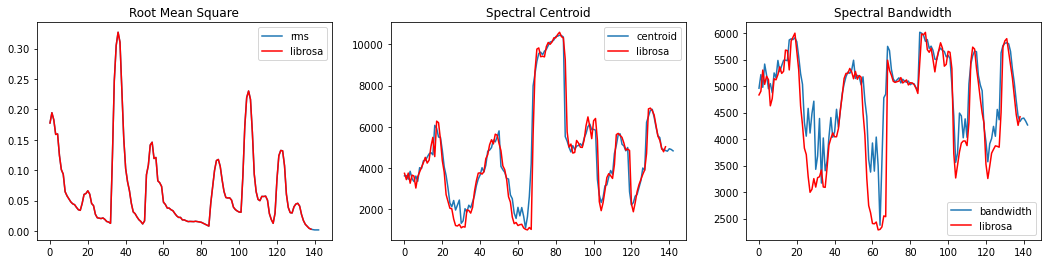

In [7]:
frame_length = 2048
hop_length = 512

rms = features.root_mean_square(x, frame_length, hop_length)
rms_librosa = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length)

cent = features.spectral_centroid(x, frame_length, hop_length)
cent_librosa = librosa.feature.spectral_centroid(y=x, sr=44100, n_fft=frame_length, hop_length=hop_length)

bandwidth = features.spectral_bandwidth(x, frame_length=frame_length, hop_length=hop_length, sr=44100, p=2)
bandwidth_librosa = librosa.feature.spectral_bandwidth(y=x, sr=44100, n_fft=frame_length, hop_length=hop_length, p=2)

# Plot the comparison between our functions and the one from librosa
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(rms, label='rms')
ax[0].plot(rms_librosa[0], color='r', label='librosa')
ax[0].set_title('Root Mean Square')
ax[0].legend()
ax[1].plot(cent, label='centroid')
ax[1].plot(cent_librosa[0], color='r', label='librosa')
ax[1].set_title('Spectral Centroid')
ax[1].legend()
ax[2].plot(bandwidth, label='bandwidth')
ax[2].plot(bandwidth_librosa[0], color='r', label='librosa')
ax[2].set_title('Spectral Bandwidth')
ax[2].legend(loc='lower right');

## Part 2
Display a 3D scatter plot of the database versus the three computed features. In the scatter plot, you should color-code entries belonging to the different instruments. Axis should be labeled and a legend should be provided associate colors with instruments.

Your program must not use any prior knowledge on the contents of the meta.csv (i.e. how many entries, which are the various labels, how many different labels are there). Everything must be computed by analyzing the data in the file (likely using Pandas). In other word, your program should also work if the contents of the database folder changes (e.g. more files, and more type of instrument), which is a test you can try to carry out to verify the robustness of your code.

In [8]:
def meta_csv(data):
    
    csv = pd.read_csv(data)
    df = pd.DataFrame(csv)

    # Get the unique values in the dataframe in order to get the instruments
    instruments = df['label'].unique()
    
    # Create empty lists for the instruments
    filenames = [[] for i in range(len(instruments))]

    for index, value in enumerate(instruments):

        filename = df.loc[(df['label'] == value)]

        for x in filename['filename']:
            filenames[index].append(x)
            
    return instruments, filenames

In [9]:
def scatter3D(instruments, filenames):
    
    # Create empty lists for the instruments
    spectral_features = [[] for i in range(len(instruments))]
    
    for index, value in enumerate(filenames):

        # Create empty lists for spectral features
        rms_instrument = []
        centroid_instrument = []
        bandwidth_instrument = []

        for val in value:

            # Selecting files by extensions
            if val.endswith('.' + 'wav'):

                audio_file = 'database/' + val

                # load audio file with librosa in mono and 44.1 kHz
                audio, sr = librosa.load(audio_file, sr=44100, mono=True)

                # Compute spectral features with features package
                rootmeansquare = features.root_mean_square(audio, len(audio), len(audio)*2)
                spectralcentroid = features.spectral_centroid(audio, len(audio), len(audio)*2)
                spectralbandwidth = features.spectral_bandwidth(audio, len(audio), len(audio)*2)

                # Append spectral features values to list
                rms_instrument.append(rootmeansquare)
                centroid_instrument.append(spectralcentroid)
                bandwidth_instrument.append(spectralbandwidth)

                x = np.concatenate(rms_instrument)
                y = np.concatenate(centroid_instrument)
                z = np.concatenate(bandwidth_instrument)

        # Extend spectral features values to the main list of lists
        spectral_features[index].extend([x, y, z])

    # Creating figure
    fig = plt.figure(figsize=(13, 13))
    ax = plt.axes(projection ="3d")

    for x, y in zip(instruments, spectral_features):

        rgb = (random.random(), random.random(), random.random())

        # Creating 3D scatter plot
        ax.scatter3D(y[0], y[1], y[2], color=[rgb], label=x, s=180)

    ax.set_xlabel('Root Mean Square', fontsize=15)
    ax.set_ylabel('Spectral Centroid (Hz)', fontsize=15)
    ax.set_zlabel('Spectral Bandwidth (Hz)', fontsize=15)
    ax.legend()

    plt.title("Instruments spectral features", fontsize=18)

Plotting the results

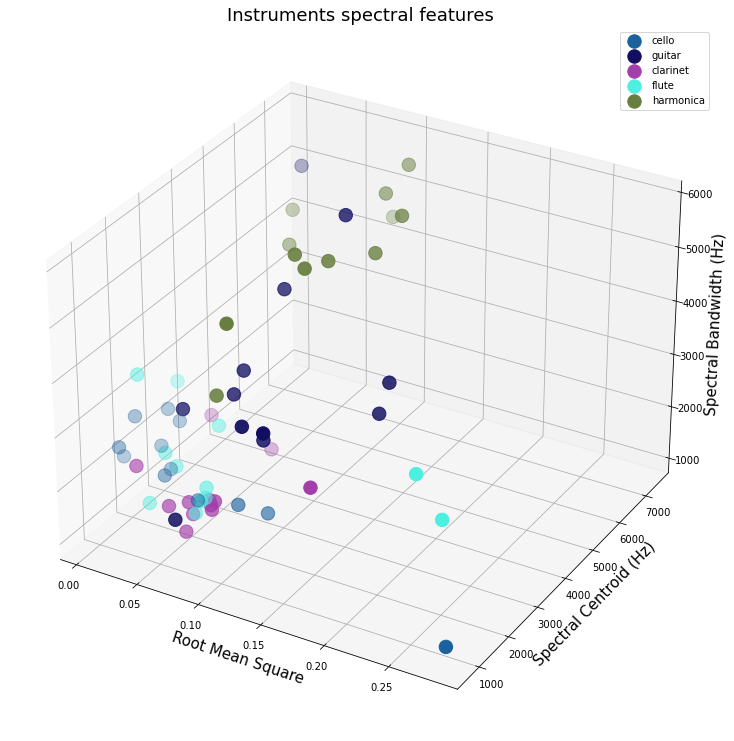

In [10]:
data = 'database/meta.csv'
instruments, filenames = meta_csv(data)
scatter3D(instruments, filenames)

## Part 3
Filter each class with a different pair of filters in cascade. The filters should be a low pass and a high pass, and their cascade should form a bandpass.
- One filter should be a second order IIR, the other a FIR of arbitrary order.
- The FIR should be applied in the frequency domain (i.e. product of the DFT of signal and filter impulse response).
- The IIR should be applied in Pure Data using the biquad object. This require you "call PD" from Python, passing input and output file names, and filter coefficients. 
- Display the overall frequency response of the various cascades you designed. 
- Filter parameters are arbitrary.
- The filtered signals should be saved as wave files using the same name as the original file followed by _filtered.wav.

In [11]:
def FIR_fft(signal, order, passband_hz, stopband_hz, pass_zero='lowpass', sr=44100):
    
    numtaps = order-1 # filter length (or number of tabs)
    
    wp = passband_hz/(sr/2) # passband edge normalized frequency
    ws = stopband_hz/(sr/2) # stopband edge normalized frequency

    freqs = [0.0, wp, ws, 1.0]
    
    if pass_zero == 'lowpass':
        gains = [1.0, 1.0, 0.0, 0.0] # normalized gain values (0.5 = -3 dB)
    elif pass_zero == 'highpass':
        gains = [0.0, 0.0, 1.0, 1.0] # normalized gain values (0.5 = -3 dB)
                
    # Compute the FIR filter coefficients 
    h = sig.firwin2(numtaps, freqs, gains, window='hann') # compute FIR coefficients using firwin2 function
    
    # Design the FIR filter in the frequency domain 
    h_padded = np.pad(h,[0,len(signal)-len(h)]) # pad FIR coefficients with zeros in order to match the signal length
    
    # Apply the discrete Fourier Transform to the FIR filter (move to the frequency domain)
    X = scipy.fft.fft(signal)
    H = scipy.fft.fft(h_padded)
    
    Y = X*H # do the product of the DFT of the signal with the padded filter impulse response
    
    # Apply the inverse discrete Fourier Transform to the FIR filter (back to the time domain)
    y = np.real(scipy.fft.ifft(Y))
        
    return h, y # FIR filter coefficients + signal filtered in the frequency domain

In [12]:
def filter_response(b, a, title, cutoff_hz):

    w, h = sig.freqz(b, a) # compute the frequency response of the filter
    w_n = w/math.pi # normalize frequency in π radians/sample
    
    fig, ax = plt.subplots()

    ax.set_title(title, fontsize=15)
    ax.plot(w_n, abs(h), color='b')
    ax.set_ylabel('Gain', color='b', fontsize=12)
    ax.set_xlabel('Normalized Frequency ($x$ $\pi$ radians/sample)', fontsize=12)
    
    cutoff = cutoff_hz / (sr/2)
    
    ax.axvline(cutoff, color='r', linestyle='--', linewidth=1, label='Cutoff')
    ax.legend(fontsize=12)
    ax.grid()

    # compute the angles of the complex numbers of the computed frequency response
    angles = []

    for i in h:

        phase = math.atan2(i.imag, i.real)
        angles.append(phase)

    # unwrap by taking the complement of large deltas with respect to the period
    unwrap_angles = np.unwrap(angles)

    ax2 = ax.twinx() # create a twin Axes sharing the xaxis
    ax2.plot(w_n, unwrap_angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g', fontsize=12)
    ax2.grid(color='g', alpha=0.3)

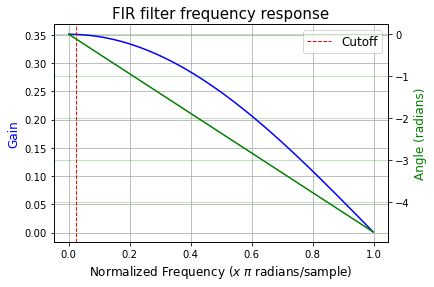

In [13]:
# create white gaussian noise 
noise = np.random.normal(0, 1, 2*sr)

order = 5
cutoff = 500

# Compute filter coefficients (h) and filter signal in the frequency domain (y)
h, y = FIR_fft(noise, order, cutoff, 10000, pass_zero='lowpass', sr=44100)

filter_response(h, 1, 'FIR filter frequency response', cutoff)

## IIR Filter Design (for pd biquad~)

In [14]:
# Defining a function to convert from hertz to normalized frequency
def hzNorm(hz, sr=44100):
    norm = hz / (sr / 2)
    if hz > sr / 2:
        print(hz, "Hz is above the Nyquist frequency for samplerate:\t", sr)
    else:
        return norm

In [15]:
# Make a Dictionary for cutoff frequencies of the different instrument groups
filterCutoffs = {}
for index, value in enumerate(instruments):
    filterCutoffs[value] = {}

# Function to fill the values
def setFilter(instrument, highpass, lowpass):
    filterCutoffs[instrument] = dict({'HighPass': highpass, 'LowPass': lowpass})

In [16]:
# Filling the values
setFilter('cello', 300, 1000)
setFilter('guitar', 300, 1500)
setFilter('clarinet', 500, 2000)
setFilter('flute', 500, 2500)
setFilter('harmonica', 1000, 6000)

# Showing the dictionary
filterCutoffs

{'cello': {'HighPass': 300, 'LowPass': 1000},
 'guitar': {'HighPass': 300, 'LowPass': 1500},
 'clarinet': {'HighPass': 500, 'LowPass': 2000},
 'flute': {'HighPass': 500, 'LowPass': 2500},
 'harmonica': {'HighPass': 1000, 'LowPass': 6000}}

In [17]:
# IIR Designs from https://www.earlevel.com/main/2021/09/02/biquad-calculator-v3/
# for good compatability with pd's biquad~ object

# HighPass 100Hz   1.98565211 -0.98585366 0.99287644 -1.98575289 0.99287644
# HighPass 100Hz   0.99287644, -1.98575289, 0.99287644, 1, -1.98565211, 0.98585366

# HighPass 150Hz   1.97840427 -0.97885616 0.98931511 -1.97863022 0.98931511
# HighPass 150Hz   0.98931511, -1.97863022, 0.98931511, 1, -1.97840427, 0.97885616

# HighPass 200Hz   1.97110834 -0.97190886 0.98575430 -1.97150860 0.98575430
# HighPass 200Hz   0.98575430, -1.97150860, 0.98575430, 1, -1.97110834, 0.97190886

# HighPass 300Hz   1.95637562 -0.95816407 0.97863492 -1.95726984 0.97863492
# HighPass 300Hz   0.97863492, -1.95726984, 0.97863492, 1, -1.95637562, 0.95816407

# HighPass 500Hz   1.92637001 -0.93126838 0.96440960 -1.92881920 0.96440960
# HighPass 500Hz   0.96440960, -1.92881920, 0.96440960, 1, -1.92637001, 0.93126838

# HighPass 1000Hz  1.84849691 -0.86741858 0.92897887 -1.85795775 0.92897887
# HighPass 1000Hz  0.92897887, -1.85795775, 0.92897887, 1, -1.84849691, 0.86741858


# Making a filterbank with the sos values
filterBank = {}
for index, value in enumerate(instruments):
    filterBank[value] = {}

for index, value in enumerate(instruments):
    if filterCutoffs[value]['HighPass'] == 100:
        filterBank[value]['sos'] = [[0.99287644, -1.98575289, 0.99287644, 1, -1.98565211, 0.98585366]]
    elif filterCutoffs[value]['HighPass'] == 150:
        filterBank[value]['sos'] = [[0.98931511, -1.97863022, 0.98931511, 1, -1.97840427, 0.97885616]]
    elif filterCutoffs[value]['HighPass'] == 200:
        filterBank[value]['sos'] = [[0.98575430, -1.97150860, 0.98575430, 1, -1.97110834, 0.97190886]]
    elif filterCutoffs[value]['HighPass'] == 300:
        filterBank[value]['sos'] = [[0.97863492, -1.95726984, 0.97863492, 1, -1.95637562, 0.95816407]]
    elif filterCutoffs[value]['HighPass'] == 500:
        filterBank[value]['sos'] = [[0.96440960, -1.92881920, 0.96440960, 1, -1.92637001, 0.93126838]]
    elif filterCutoffs[value]['HighPass'] == 1000:
        filterBank[value]['sos'] = [[0.92897887, -1.85795775, 0.92897887, 1, -1.84849691, 0.86741858]] 

for index, value in enumerate(filterBank):
    a1 = str(filterBank[value]['sos'][0][4] * -1)
    a2 = str(filterBank[value]['sos'][0][5] * -1)
    b1 = str(filterBank[value]['sos'][0][0])
    b2 = str(filterBank[value]['sos'][0][1])
    b3 = str(filterBank[value]['sos'][0][2])
    biquad = str(a1 + ' ' + a2 + ' ' + b1 + ' ' + b2 + ' ' + b3)
    
    filterBank[value]['biquad'] = biquad
    

In [18]:
display(filterBank.keys())
display(filterBank['harmonica'])

dict_keys(['cello', 'guitar', 'clarinet', 'flute', 'harmonica'])

{'sos': [[0.92897887, -1.85795775, 0.92897887, 1, -1.84849691, 0.86741858]],
 'biquad': '1.84849691 -0.86741858 0.92897887 -1.85795775 0.92897887'}

## The pd-class:

In [19]:
class PdFilter:

    
    # Set your pd path below (for Mac)
    pd_path = '/Applications/Pd-0.51-4.app'

    
    # Initialize instance
    def __init__(self, instrument, files, biquad, pd_path=pd_path):
        
        self.instrument = instrument
        self.files = files
        self.biquad = biquad
        
        # Number of files to process in this instrument group
        number = 0
        for num in files:
                number += 1
        self.filecount = number
       
    # Representation in Python interpreter
    def __repr__(self):
        return f'PdFilter ({self.instrument})'

    # Function to send the files to pd
    #
    # WORK IN PROGRESS
    def send2pd(self):

        # pd executable
        if os.sys.platform == 'darwin':
            pd_exec = self.pd_path + '/Contents/Resources/bin/pd' #for Mac
        elif os.sys.platform == 'win32':
            pd_exec = '"C:\\Program Files\\Pd\\bin\\pd.exe"' #for Windows
            
        # pd patch
        pd_patch = 'readsf_batch.pd'    

        
        # test pd msg with temp biquad numbers
        # pd_send = ' -send "; pd dsp 1; biquad 1 -0.772330 0.023470 0.023470 0; readName 4.wav; writeName 4_filtered.wav"'

        
        for file in self.files:
            readfile = 'database/' + os.path.splitext(file)[0] + '.wav'
            filterfile = 'database/' + os.path.splitext(file)[0] + '_filtered.wav'
                 
            # pd message (The lower for testing until biquad implemented)
            pd_send = ' -send "; pd dsp 1; biquad ' + self.biquad + '; readName ' + readfile + '; writeName ' + filterfile + '"'
            #pd_send = ' -send "; pd dsp 1; biquad -0.77233058 0 0.02347075 0.02347075 0; readName ' + readfile + '; writeName ' + filterfile + '"'

            #pd_send = ' -send "; pd dsp 1; biquad 1.92637001 -0.93126838 0.96440960 -1.92881920 0.96440960; readName ' + readfile + '; writeName ' + filterfile + '"'

            
            #array([ 0.99999954, -1.99999909,  0.99999954]) - -1 -2 
            #array([ 1.        , -1.99999909,  0.99999909]) 3 4 5
            
            #array([ 0.99999817, -1.99999634,  0.99999817])
            #array([ 1.        , -1.99999634,  0.99999634])
            
            # execute
            pd_command = pd_exec + ' -open ' + pd_patch + pd_send + ' -nogui' + ' -batch'
            
            os.popen(pd_command)
            
            # Function to remove temp-files (for the final version)
            # os.remove(readfile)

        

In [20]:
# Function for making an instance of the PdFilter class pr instrument group for pd filtering

def pdClassGen():

    # Making a dictionary to sort the .wav-files by instrument
    sortedfiles = {}
    for index, value in enumerate(instruments):
        sortedfiles[value] = filenames[index]

    classy = list()
    for instrument in sortedfiles:
        classy.append(PdFilter(instrument, sortedfiles[instrument], filterBank[instrument]['biquad']))

    
    return classy

In [21]:
py2pd = pdClassGen()
py2pd

[PdFilter (cello),
 PdFilter (guitar),
 PdFilter (clarinet),
 PdFilter (flute),
 PdFilter (harmonica)]

In [22]:
# Example of the contents of first class instance:
display(py2pd[0].instrument)
display(py2pd[0].files)
display(py2pd[0].biquad)

'cello'

['699385f4.wav',
 '756fc6fa.wav',
 '508e8e56.wav',
 '6a210ffa.wav',
 '54bb57af.wav',
 '5689818f.wav',
 '53d1ed2b.wav',
 '5e5bca7a.wav',
 '4d68f059.wav',
 '5e4477e9.wav',
 '515a7743.wav',
 '62ff9fde.wav']

'1.95637562 -0.95816407 0.97863492 -1.95726984 0.97863492'

### Process every .wav through pd
Every instrumentgroup has its own class instance with individual files and biquad settings. Due to the CPU needed to batch process every .wav at once in pd (our computer went to 'lockdown' and force-restarted when trying), we're replacing the code below individual cells per instrument group, for pd processing.

```python
for obj in py2pd:
    obj.send2pd()
```

In [23]:
# Cello filtering
display(py2pd[0].instrument)
#py2pd[0].send2pd()

'cello'

In [24]:
# Guitar filtering
display(py2pd[1].instrument)
#py2pd[1].send2pd()

'guitar'

In [25]:
# Clarinet filtering
display(py2pd[2].instrument)
#py2pd[2].send2pd()

'clarinet'

In [26]:
# Flute filtering
display(py2pd[3].instrument)
#py2pd[3].send2pd()

'flute'

In [27]:
# Harmonica filtering
display(py2pd[4].instrument)
#py2pd[4].send2pd()

'harmonica'

---

### Sofia's Rename/Filewriter

In [28]:
import soundfile as sf
from soundfile import write


def saveaswav(signal_array, sr):
    csv = pd.read_csv('./meta.csv')
    df = pd.DataFrame(csv)
    names = [] #list where to store the '_filtered.wav' names
    
    for i in range(df['filename'].size):
        if df['filename'][i].endswith('.wav') == True:
            df['filename'][i] = df['filename'][i].replace('.wav', '_filtered.wav')
            names.append(df['filename'][i])
        
        sf.write(names[i], signal_array, sr)
        print('File saved as: {}'.format(names[i]))